# ECON320 Week 9 — Inference: *t* & *F* Tests (Completed version)


**Learning goals**

* Build intuition on p-values of t-test: 
    - *How surprising is my estimate if the true effect were zero?*

* Conduct and interpret single–coefficient (*t*) tests

* See the *t*-statistic converge to a standard normal as *n* grows.

* Motivate and run multi–coefficient (*F*) tests using `statsmodels`.

---

## 📦 Required libraries

In [1]:

!pip install -q numpy pandas statsmodels scipy matplotlib

import numpy as np, pandas as pd
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
np.random.seed(320)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


---

## 1) Motivation for t-tests: compare your estimate to a **0-mean normal under H₀**

- **Imagine first.**  

  - When we estimate OLS on different random samples from the same population, the coefficients will vary because of sampling variability.  

  - That’s why we test:

    - scale the estimate by its standard error ($t=\hat\beta/\text{SE}$), and  

    - use a two-sided $p$-value under $H_0:\beta_j=0$ to ask “how surprising would I get this estimated number if the true effect were zero?”

<hr style="border: 1px dotted #bbb;">

**Setup.** Suppose we want to test a single coefficient in a linear model (with an intercept):
$$
y_i = \beta_0 + \beta_1 x_{1i} + \cdots + \beta_k x_{ki} + u_i.
$$
We test $H_0:\beta_j=0$  vs $H_1:\beta_j\neq 0$.

<hr style="border: 1px dotted #bbb;">

> **Some distribution facts.**
>
> - **Exact (classical normal errors; MLR.6):** Define the **test statistic (random variable)**
> $$
> T_j \;=\; \frac{\hat\beta_j-\beta_j}{\widehat{SE}(\hat\beta_j)},\qquad \mathrm{df}=n-(k+1).
> $$
> Under $H_0$, 
> $$
>   T_j\;=\; \frac{\hat\beta_j-0}{\widehat{SE}(\hat\beta_j)}\sim t_{\mathrm{df}}
> $$ (finite-sample exact)
>
>
>
> - **Large sample (no normality needed):** first the standard asymptotic normality
> $$
> \sqrt{n}\,\big(\hat\beta_j-\beta_j\big)\ \xrightarrow{d}\ \mathcal N\!\big(0,\ \mathrm{AVAR}(\hat\beta_j)\big),
> $$
> which implies under $H_0$
> $$
> T_j \;\approx\; \mathcal N(0,1)\quad \text{for large } n.
> $$

<hr style="border: 1px dotted #bbb;">

**Observed value.** After you plug in your sample, you get the **realized statistic**
$$
t_{\text{obs}} \;=\; \frac{\hat\beta_j-0}{\widehat{SE}(\hat\beta_j)}
$$

**Two-sided $p$-value (default in packages).**
$$
p \;=\; 2\,P\big(|t_{\mathrm{df}}| \ge |t_{\text{obs}}|\big)
\;=\; 2\big(1 - F_{t,\mathrm{df}}(|t_{\text{obs}}|)\big),
$$
where $t_{\mathrm{df}}$ denotes a Student-$t$ random variable with $\mathrm{df}=n-(k+1)$ and $F_{t,\mathrm{df}}$ is its CDF.

>**Intuition.**  
>
> “If the truth were **no effect** (mean zero), what is the probability that random sampling alone would produce an estimate at least this far from 0?”

<hr style="border: 1px dotted #bbb;">

**Some examples (apply the recipe).** Assume the same standard error, $\text{SE}=0.20$.
- $\hat\beta=0.10 \Rightarrow t_{\text{obs}}=0.50 \Rightarrow$ two-sided $p\approx 0.62$ (not surprising under $H_0$).  
- $\hat\beta=0.001 \Rightarrow t_{\text{obs}}=0.005 \Rightarrow$ two-sided $p\approx 0.996$ (not surprising).  
- $\hat\beta=0.50 \Rightarrow t_{\text{obs}}=2.50 \Rightarrow$ two-sided $p\approx 0.012$ (surprising if $H_0$ were true).

> **Common pitfalls.** 
> - It’s **not** the probability that $H_0$ is true
> - and a small $p$ **does not** measure effect size or practical importance.


<hr style="border: 1px dotted #bbb;">

### 🔭 Tiny visual: exact Student‑$t$ (finite sample) with normal overlay (asymptotic)

We shade the two‑sided $p$ under the **$t_{\mathrm{df}}$** curve (exact under normal errors) and overlay the **$\mathcal N(0,1)$** curve to show how $t$ approaches normal as df grows.

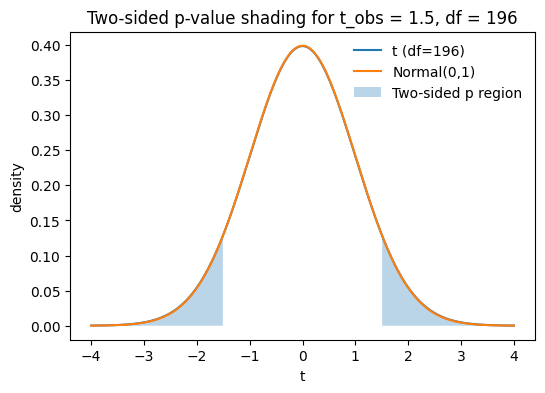

In [2]:
# Two-sided shading under a Student-t distribution (with legend)
t_obs = 1.5      # change this to demo different cases
n = 200
k = 3
df_demo = n - (k + 1)  # set to something like n-(k+1); increase to see it approach normal

xs = np.linspace(-4, 4, 800)
plt.figure(figsize=(6,4))

# Curves
plt.plot(xs, stats.t.pdf(xs, df=df_demo), label=f"t (df={df_demo})")
plt.plot(xs, stats.norm.pdf(xs), label="Normal(0,1)")

# Shaded two-sided p region under t
mask = (xs <= -abs(t_obs)) | (xs >= abs(t_obs))
plt.fill_between(xs, 0, stats.t.pdf(xs, df=df_demo), where=mask, alpha=0.3, label="Two-sided p region")

plt.title(f"Two-sided p-value shading for t_obs = {t_obs}, df = {df_demo}")
plt.xlabel("t"); plt.ylabel("density")
plt.legend(loc="upper right", frameon=False)
plt.show()


---


## 2) Single‑coefficient *t* test in practice

### Workflow (two-sided *t*-test)

1. Fit the regression and read off $\hat\beta_j$ and $\widehat{\operatorname{SE}}(\hat\beta_j)$.
2. Compute the observed statistic
   $$
   t_{\text{obs}} \;=\; \frac{\hat\beta_j-0}{\widehat{\operatorname{SE}}(\hat\beta_j)}
   $$
3. Reference distribution: Student-$t$ with $\mathrm{df}=n-(k+1)$. Two-sided $p$-value:
   $$
   p \;=\; 2\,P\!\big(|t_{\mathrm{df}}|\ge |t_{\text{obs}}|\big).
   $$
4. **Decision rule (significance level $\alpha$):** reject $H_0$ (saying $\beta_1$ is statistically significant) **iff** $p<\alpha$  

<hr style="border: 1px dotted #bbb;">

### Code: synthetic data + a single‑coefficient *t* test
### Setting for this demo: synthetic data where the null is true for $\,\beta_1\,$

We simulate a simple linear DGP with an intercept and **three** regressors, then fit OLS and test one coefficient.

**Data-generating process (DGP).**
$$
y_i \;=\; \beta_0 \;+\; \beta_1 x_{1i} \;+\; \beta_2 x_{2i} \;+\; \beta_3 x_{3i} \;+\; u_i,
$$
with $n=200$ and
- true coefficients: $\beta_0=1,\ \beta_1=0,\ \beta_2=0.8,\ \beta_3=-0.5$  (so $H_0:\beta_1=0$ is **true**),
- regressors: $x_1,x_2,x_3 \sim \mathcal N(0,1)$ (independent draws),
- errors: $u \sim \mathcal N(0,1)$, independent of the $x$’s.



In [3]:

# --- DGP ---
n = 200
x1 = np.random.normal(size=n)
x2 = np.random.normal(size=n)
x3 = np.random.normal(size=n)

# True coefficients
beta0, beta1, beta2, beta3 = 1.0, 0.0, 0.8, -0.5  # H0 is true for beta1
u = np.random.normal(size=n)
y = beta0 + beta1*x1 + beta2*x2 + beta3*x3 + u

# --- DataFrame ---
X = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3})

In [4]:
# --- Fit OLS ---
X = sm.add_constant(X)  # adds intercept
m = sm.OLS(y, X).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     58.40
Date:                Fri, 31 Oct 2025   Prob (F-statistic):           5.10e-27
Time:                        05:13:09   Log-Likelihood:                -288.58
No. Observations:                 200   AIC:                             585.2
Df Residuals:                     196   BIC:                             598.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9139      0.073     12.434      0.0

**How to read it (formal).**

- Under $H_0:\beta_1=0$ and classical normal errors, $T_1\sim t_{\mathrm{df}}$ with $\mathrm{df}=n-(k+1)$.
- The two-sided $p$-value is
$$
p \;=\; 2\,P\!\big(|t_{\mathrm{df}}|\ge |t_{\text{obs}}|\big),\qquad
t_{\text{obs}}=\frac{\hat\beta_1-0}{\widehat{\mathrm{SE}}(\hat\beta_1)}.
$$
-  Decision rule (significance level $\alpha$): reject $H_0$ (saying $\beta_1$ is statistically significant) **iff** $p<\alpha$  


> *Intuition.* The two-sided $p$-value is a **surprise index** under a 0-mean null: small $p$ means the observed $t$ would be rare if $\beta_1=0$.

---

## 4) From *t* to *F*: testing **multiple** coefficients at once

**Why we need *F*.** A *t* test asks a yes/no question about **one** coefficient. Often the scientific question is: *“Do this **group** of variables jointly matter?”* Example:
$$
H_0:\ \beta_2=0\ \text{and}\ \beta_3=0 \quad (q=2\ \text{restrictions}).
$$


<hr style="border: 1px dotted #bbb;">

**Idea:** Compare model fit **with** and **without** the restricted variables.

- **Unrestricted (UR):** intercept + $x_1,x_2,x_3$; residual sum of squares $\text{SSR}_{UR}$; parameters $p=4$ (const + 3 slopes); df $= n-p$.
- **Restricted (R):** intercept + $x_1$ only; residual sum of squares $\text{SSR}_R$; parameters $p-q=2$; df $= n-(p-q)$.

<hr style="border: 1px dotted #bbb;">

**Test statistic**
$$
F \;=\; \frac{(\text{SSR}_R - \text{SSR}_{UR})/q}{\,\text{SSR}_{UR}/(n-p)\,} 
\;\sim\; F(q,\,n-p)\quad \text{under } H_0.
$$

> **Intuition (plain language).**
> - If adding $x_2,x_3$ makes $\text{SSR}$ **drop a lot** (relative to the noise level $\text{SSR}_{UR}/(n-p)$), they’re probably **important** predictors ⇒ $F$ **large** ⇒ **small** $p$ ⇒ > evidence **against** $H_0$.
> - If $\text{SSR}$ hardly changes, $F$ stays **small** ⇒ $p$ **large** ⇒ little evidence against $H_0$.


<hr style="border: 1px dotted #bbb;">

**Decision rule (level $\alpha$).**
- **$p$-value:** reject $H_0$ iff
$$
p \;=\; P\!\big(F_{q,\,n-p}\ge F_{\text{obs}}\big) \;<\; \alpha.
$$


> **Note.** The “F-statistic” at the top of `fit.summary()` is the **overall** test $H_0:\beta_1=\beta_2=\beta_3=0$. For subsets (e.g., $\beta_2=\beta_3=0$), use `f_test(...)`.

<hr style="border: 1px dotted #bbb;">

### Code: Compute *F* test manually and via `statsmodels` `f_test`


In [5]:
# Joint test H0: x2 = 0 and x3 = 0  (q = 2)

# Fit UR (const + x1 + x2 + x3) and R (const + x1)
X_ur = sm.add_constant(pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3}))
fit_ur = sm.OLS(y, X_ur).fit()
X_r  = sm.add_constant(pd.DataFrame({'x1': x1}))
fit_r = sm.OLS(y, X_r).fit()

# Manual F
SSR_UR, SSR_R = fit_ur.ssr, fit_r.ssr
q = 2
n, p = int(fit_ur.nobs), X_ur.shape[1]
df2 = n - p
F_manual = ((SSR_R - SSR_UR)/q) / (SSR_UR/df2)
p_manual = 1 - stats.f.cdf(F_manual, q, df2)
print({'F_manual': float(F_manual), 'p_manual': float(p_manual), 'df1': q, 'df2': df2})

# statsmodels f_test (same null)
print(fit_ur.f_test("x2 = 0, x3 = 0"))

# Optional decision (two-sided, level alpha)
alpha = 0.05
print("Decision @ alpha=0.05:", "REJECT H0" if p_manual < alpha else "Do NOT reject H0")

{'F_manual': 87.56190320272353, 'p_manual': 1.1102230246251565e-16, 'df1': 2, 'df2': 196}
<F test: F=87.56190320272353, p=6.7336608095612395e-28, df_denom=196, df_num=2>
Decision @ alpha=0.05: REJECT H0


---
## References & Acknowledgments

- This teaching material was prepared with the assistance of **OpenAI's ChatGPT (GPT-5)**.

---

**End of lecture notebook.**